In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import os

In [2]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [3]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]

In [4]:
X = np.load("../data/train.npy")
X = np.concatenate([X,np.load("../data/train_qformer.npy")], axis=1)
X = np.concatenate([X,np.load("../data/train_desc_mean.npy")], axis=1)

V = np.load("../data/val.npy")
V = np.concatenate([V,np.load("../data/val_qformer.npy")], axis=1)
V = np.concatenate([V,np.load("../data/val_desc_mean.npy")], axis=1)
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [5]:
X.shape, V.shape

(torch.Size([124145, 4736]), torch.Size([19330, 4736]))

In [6]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)

In [7]:
model = nn.Sequential(
    nn.Linear(4736, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=4736, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [9]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [10]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.172455072402954, acc 0.6996012926101685 val_acc 0.6467149257659912
Finished epoch 1, latest loss 0.6077760457992554, acc 0.7649683952331543 val_acc 0.6686497926712036
Finished epoch 2, latest loss 0.873694896697998, acc 0.796334981918335 val_acc 0.6616657972335815
Finished epoch 3, latest loss 0.5289120674133301, acc 0.8174876570701599 val_acc 0.6588205099105835
Finished epoch 4, latest loss 0.48736661672592163, acc 0.8302227258682251 val_acc 0.6682876348495483
Finished epoch 5, latest loss 0.411200612783432, acc 0.8419992923736572 val_acc 0.6481634974479675
Finished epoch 6, latest loss 0.48391857743263245, acc 0.8506585359573364 val_acc 0.6440248489379883
Finished epoch 7, latest loss 0.2669258713722229, acc 0.8599380254745483 val_acc 0.6454733610153198
Finished epoch 8, latest loss 0.34853604435920715, acc 0.8654396533966064 val_acc 0.6528711915016174
Finished epoch 9, latest loss 0.20470081269741058, acc 0.8726489543914795 val_acc 0.6337299346923828


In [17]:
final = nn.Sequential(model, torch.nn.Softmax(dim = 1))
val_pred = utils.evaluate(V, final, device, batch_size)

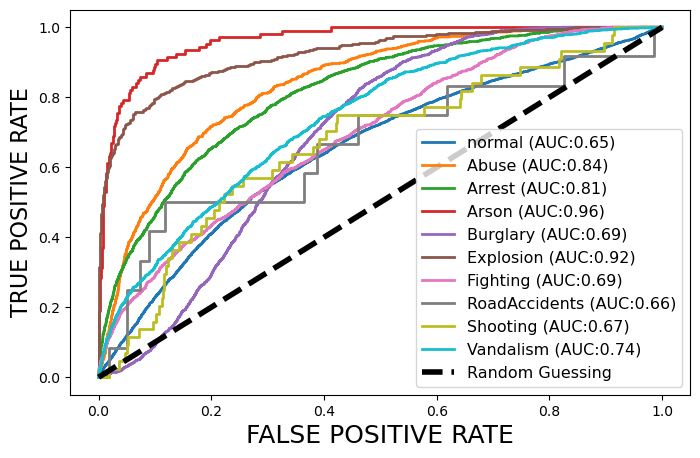

ROC AUC score: 0.7648007477359501


In [26]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

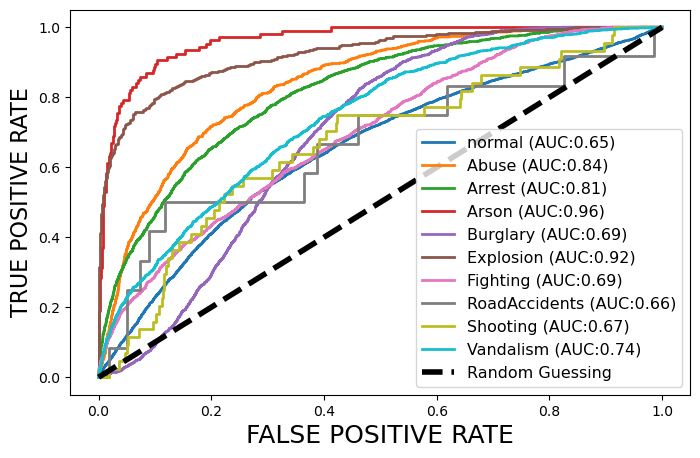

ROC AUC score: 0.6880853773073383


In [25]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "weighted"))

In [19]:
utils.get_acc_per_lbl(val_pred, y_val)
print("Acc:", utils.get_acc(val_pred, y_val))

0, presc 0.70, recall 0.85, f1 0.77	 total 12895 Normal
1, presc 0.21, recall 0.18, f1 0.19	 total 646 Abuse
2, presc 0.65, recall 0.05, f1 0.09	 total 1321 Arrest
3, presc 0.17, recall 0.58, f1 0.26	 total 106 Arson
4, presc 0.08, recall 0.09, f1 0.09	 total 1767 Burglary
5, presc 0.83, recall 0.24, f1 0.38	 total 388 Explosion
6, presc 0.36, recall 0.04, f1 0.07	 total 1132 Fighting
7, presc 0.00, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.00, recall 0.00, f1 nan	 total 44 Shooting
9, presc 0.33, recall 0.09, f1 0.15	 total 1019 Vandalism
Acc: tensor(0.6000)


In [14]:
torch.save(model.state_dict(), "models/model_image_all_features.pt")